In [41]:
import py21cmfast as p21c
from py21cmfast import plotting
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import numpy as np
from scipy.spatial.transform import Rotation
from astropy import units as un
%matplotlib inline


print(f"21cmFAST version is {p21c.__version__}")
# user_params = p21c.UserParams(
#     HII_DIM=256, BOX_LEN=512,
#     NON_CUBIC_FACTOR = 2,
# )

params_ranges = dict(
    ION_Tvir_MIN = [4,6],
    HII_EFF_FACTOR = [10, 250],
    )
kwargs = dict( 
    BOX_LEN= 128,#64, #32 is too small ,#128,
    HII_DIM= 64,#128, # to get 0.5 comving Mpc resolution #64,
    redshift=[7.51, 11.93],
    NON_CUBIC_FACTOR = 1,#16,#32,
    R_BUBBLE_MAX = 10,
    )

lightcone = p21c.run_lightcone(
    redshift = 7.51,
    max_redshift = 11.93,
    # global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_backup',
    user_params=kwargs,
    astro_params = p21c.AstroParams(kwargs),
    random_seed = 5,
    write = False,
    # regenerate = True,
)

21cmFAST version is 3.3.1


In [89]:
0 != None

True

In [86]:
import numpy as np
data = np.arange(3*17).reshape(-1,3)
print(data)
print(data.shape[0])
print(np.ceil(data.shape[0]//4))
for d in np.array_split(data, 5.9, axis=0):
    print(d)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]
 [30 31 32]
 [33 34 35]
 [36 37 38]
 [39 40 41]
 [42 43 44]
 [45 46 47]
 [48 49 50]]
17
4.0
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
[[12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]]
[[24 25 26]
 [27 28 29]
 [30 31 32]]
[[33 34 35]
 [36 37 38]
 [39 40 41]]
[[42 43 44]
 [45 46 47]
 [48 49 50]]


In [74]:
np.ceil?

Call signature:  np.ceil(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'ceil'>
File:            ~/.conda/envs/21cmFAST/lib/python3.9/site-packages/numpy/__init__.py
Docstring:      
ceil(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Return the ceiling of the input, element-wise.

The ceil of the scalar `x` is the smallest integer `i`, such that
``i >= x``.  It is often denoted as :math:`\lceil x \rceil`.

Parameters
----------
x : array_like
    Input data.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition 

In [72]:
np.array_split?

Signature:       np.array_split(ary, indices_or_sections, axis=0)
Call signature:  np.array_split(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function array_split at 0x2aaab70700d0>
File:            ~/.conda/envs/21cmFAST/lib/python3.9/site-packages/numpy/lib/shape_base.py
Docstring:      
Split an array into multiple sub-arrays.

Please refer to the ``split`` documentation.  The only difference
between these functions is that ``array_split`` allows
`indices_or_sections` to be an integer that does *not* equally
divide the axis. For an array of length l that should be split
into n sections, it returns l % n sub-arrays of size l//n + 1
and the rest of size l//n.

See Also
--------
split : Split array into multiple sub-arrays of equal size.

Examples
--------
>>> x = np.arange(8.0)
>>> np.array_split(x, 3)
[array([0.,  1.,  2.]), array([3.,  4.,  5.]), array([6.,  7.])]

>>> x = np.arange(9)
>>> np.array_split(x, 4)
[array([0, 1, 2]), array([3, 4]), array(

In [42]:
print(lightcone.__dir__())
print("shape =", lightcone.brightness_temp.shape)
print("dimensions =", lightcone.lightcone_dimensions)

['redshift', 'random_seed', 'user_params', 'cosmo_params', 'astro_params', 'flag_options', 'node_redshifts', 'cache_files', 'log10_mturnovers', 'log10_mturnovers_mini', 'global_params', 'global_brightness_temp', 'global_xH', 'photon_nonconservation_data', 'brightness_temp', 'global_quantities', 'lightcones', '__module__', '__doc__', '__init__', 'global_xHI', 'cell_size', 'lightcone_dimensions', 'shape', 'n_slices', 'lightcone_coords', 'lightcone_distances', 'lightcone_redshifts', '_particular_rep', '_write_particulars', '_read_inputs', '_read_particular', '__eq__', '__hash__', 'get_cached_data', 'gather', '_get_prefix', '_input_rep', 'get_unique_filename', '_write', 'save', 'read', '__dict__', '__weakref__', '__repr__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
shape = (64, 64, 514)
di

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

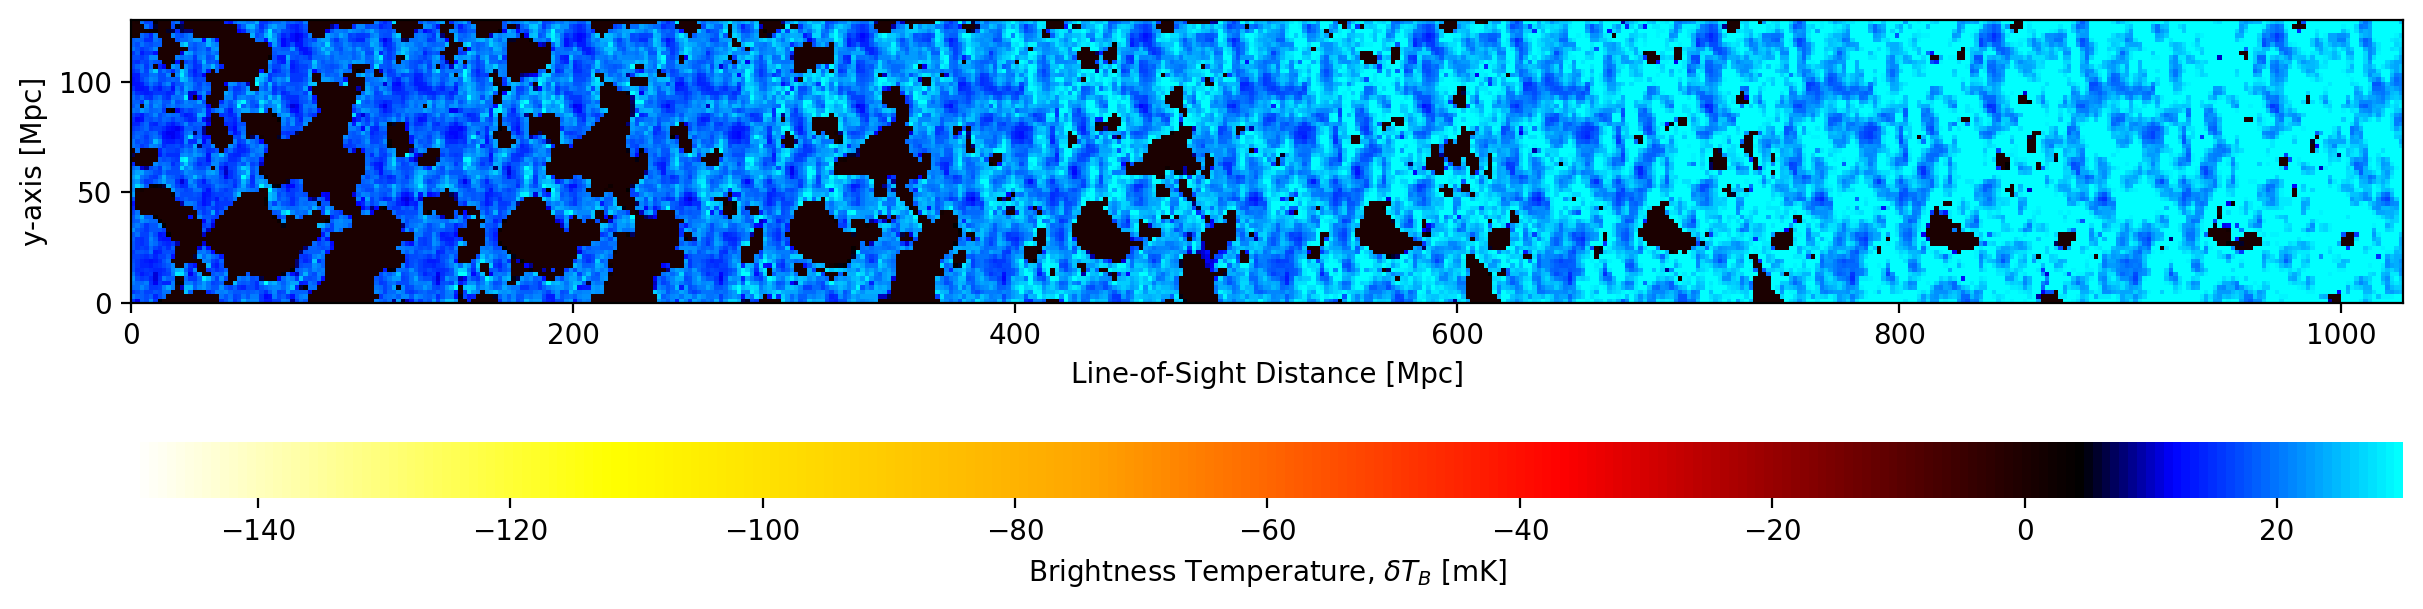

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

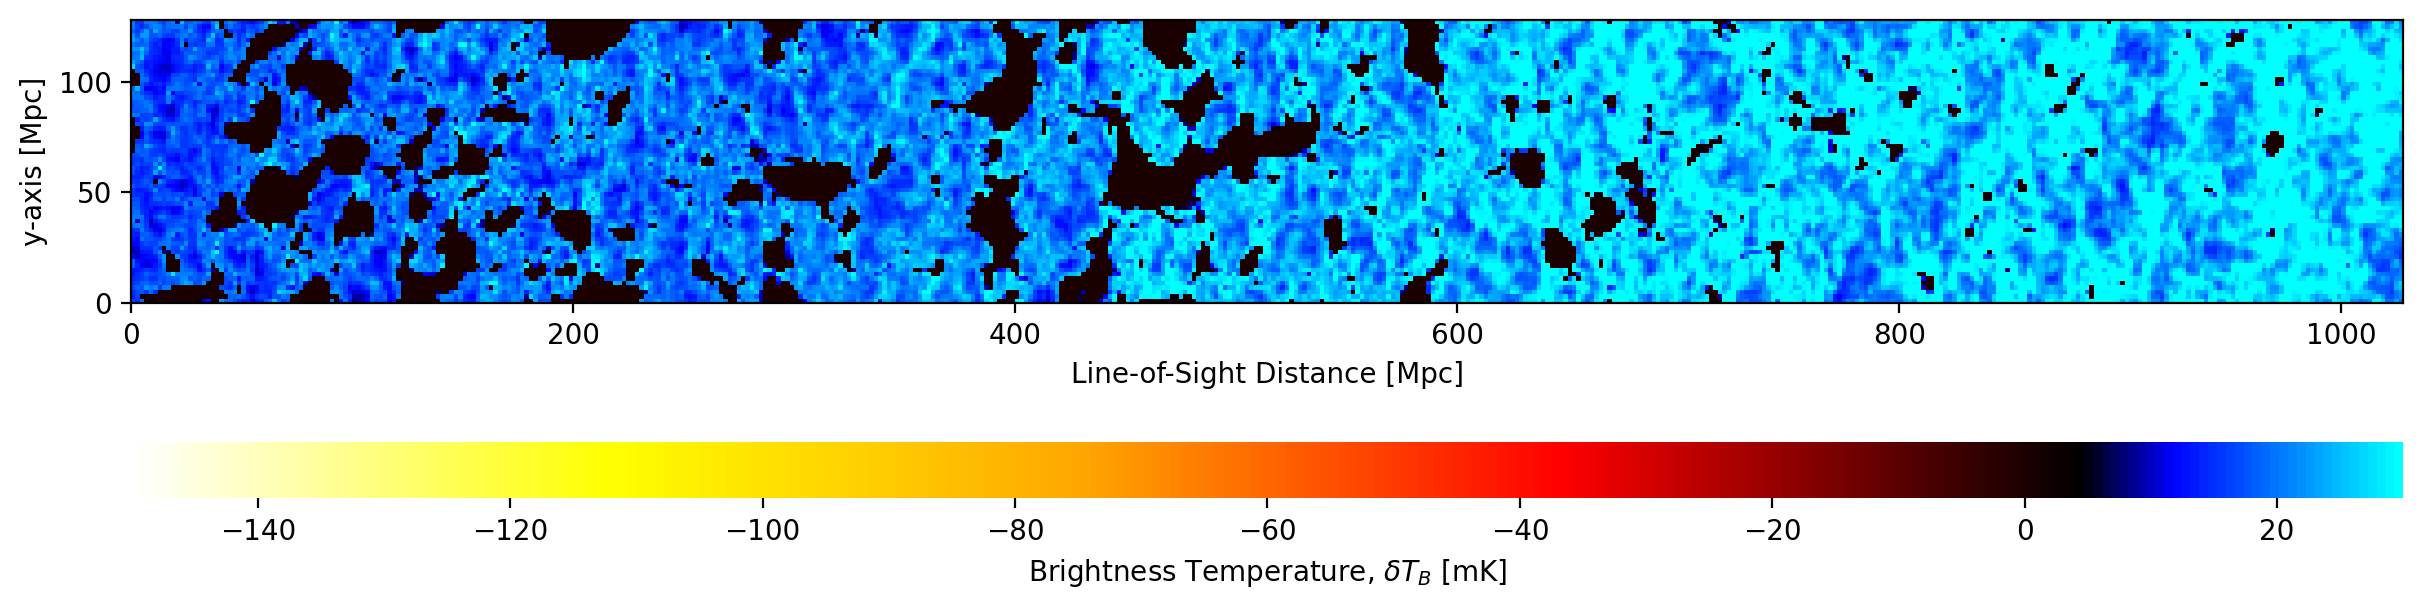

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

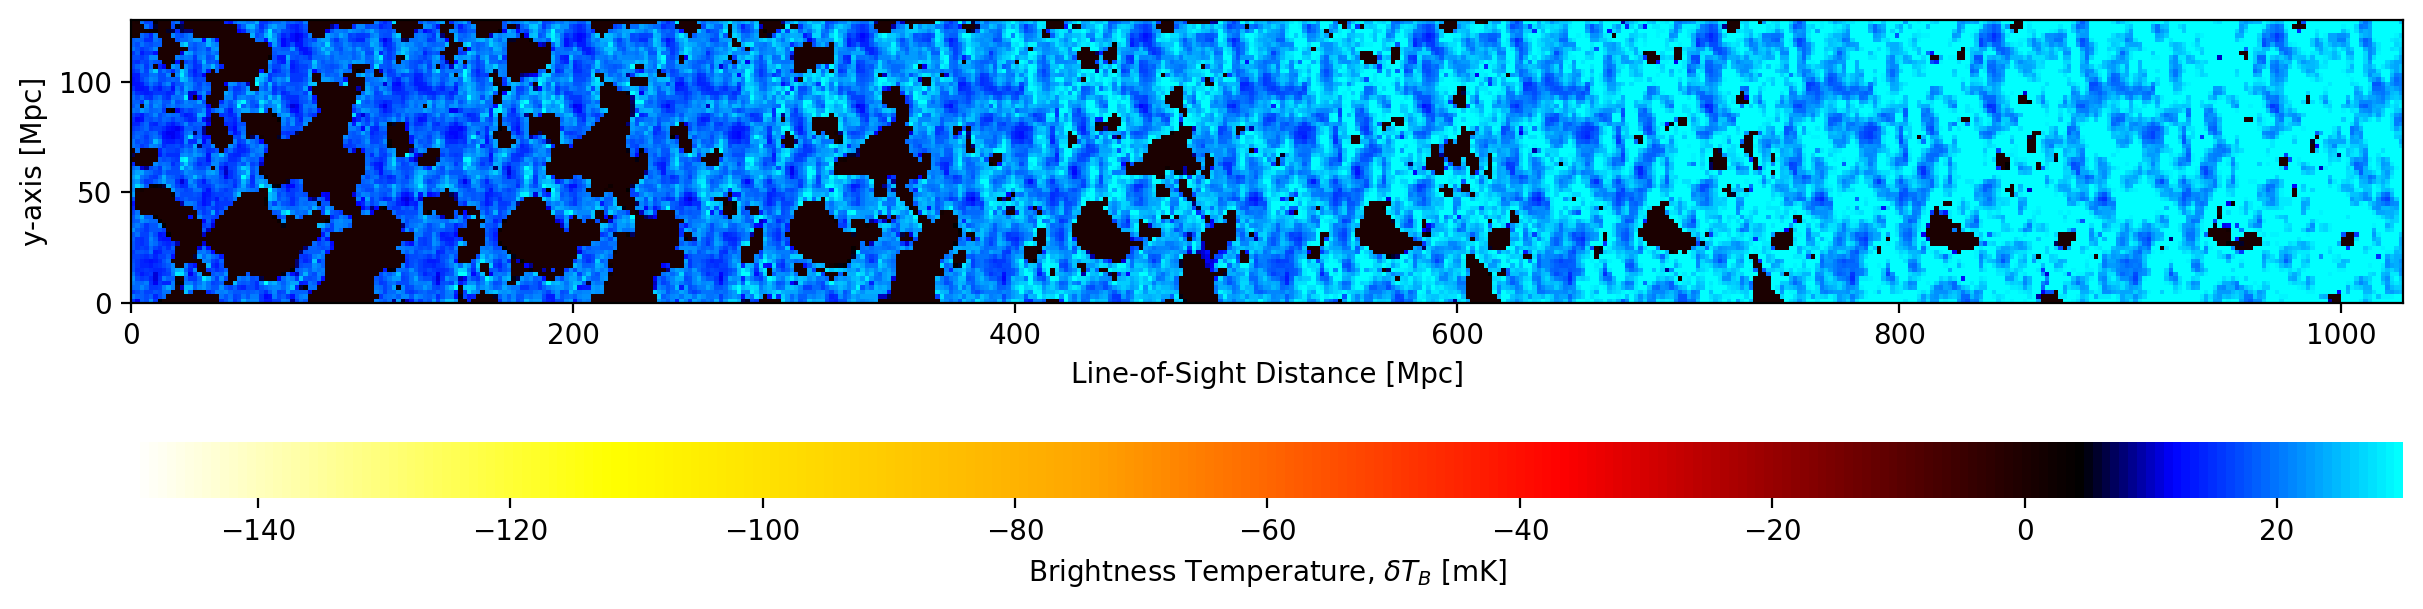

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

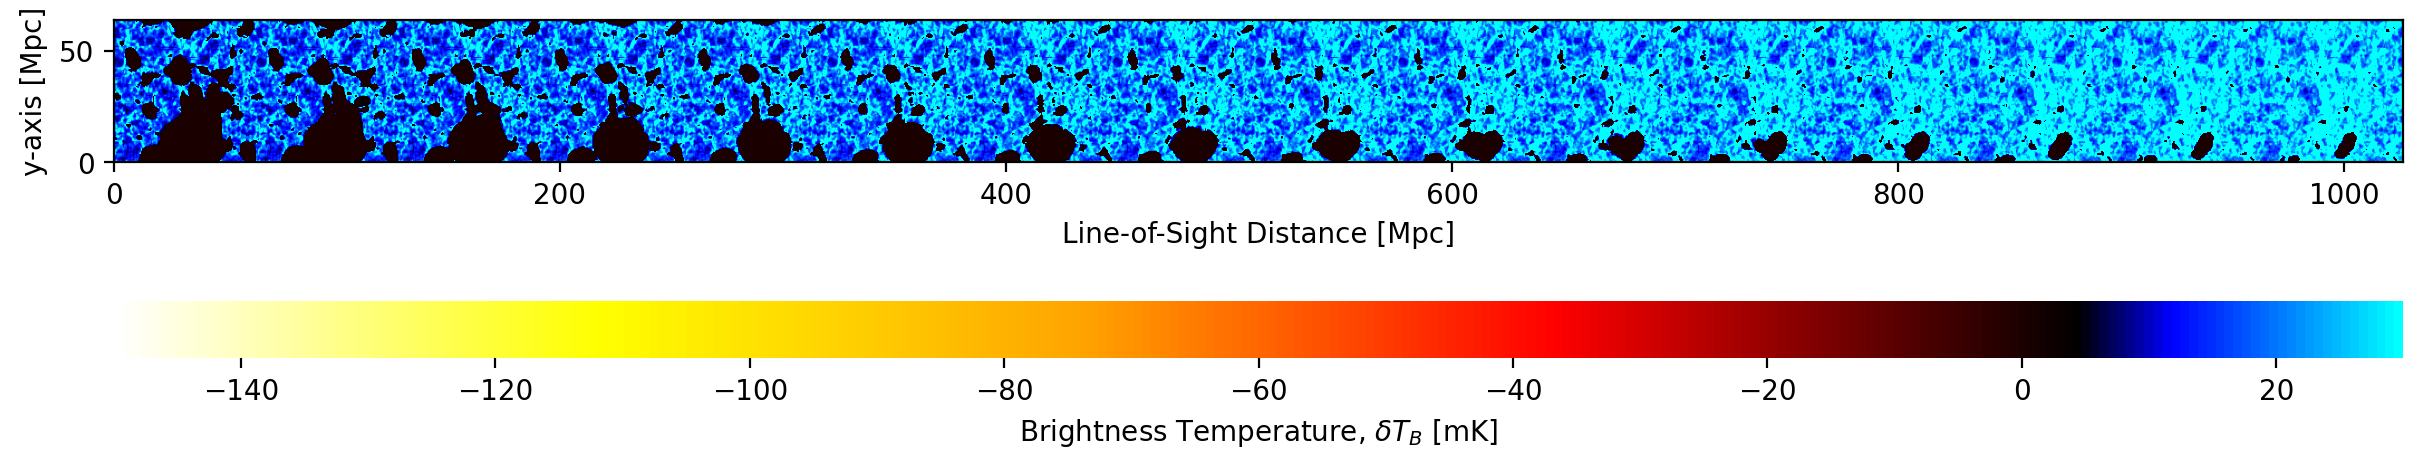

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

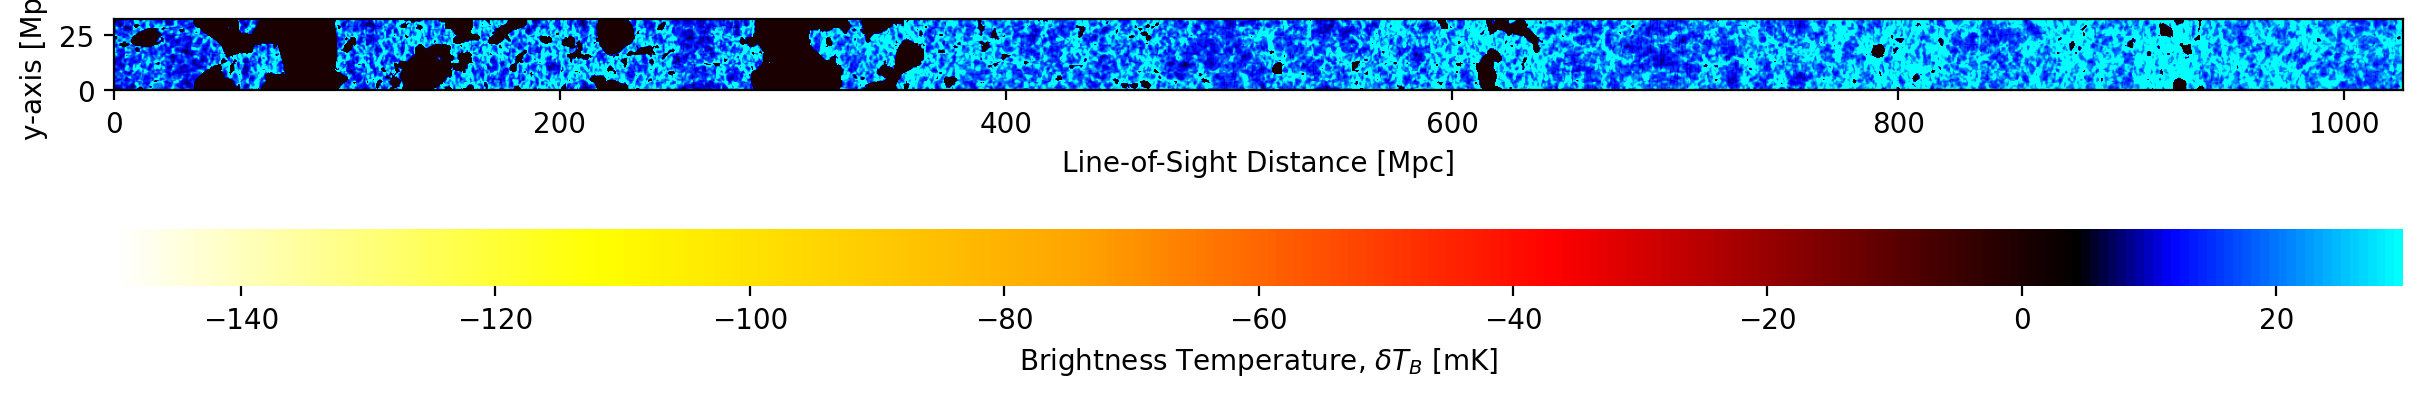

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

(<Figure size 2400x1200 with 2 Axes>,
 <Axes: xlabel='Line-of-Sight Distance [Mpc]', ylabel='y-axis [Mpc]'>)

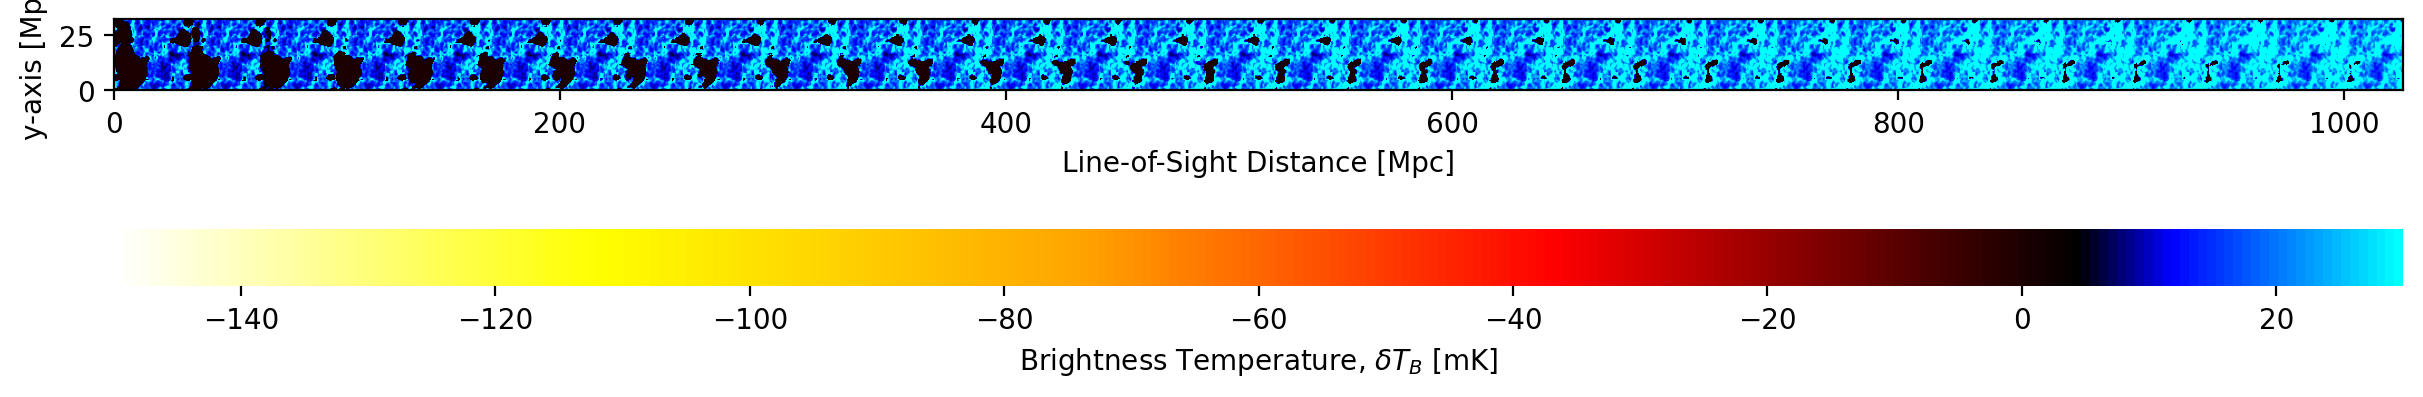

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True, dpi=200)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig, zticks='distance')

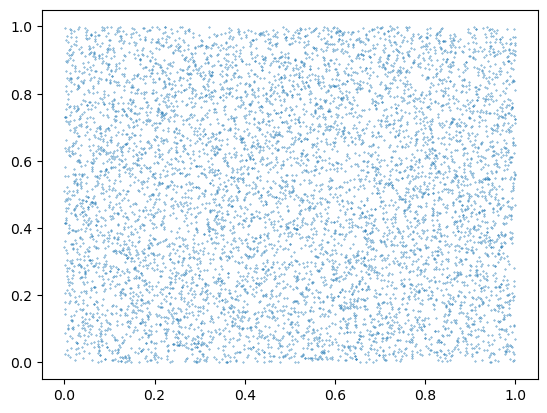

In [15]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(2)
sample = sampler.random(n=int(30000/4))
plt.scatter(sample.T[0], sample.T[1], s=0.1)

In [20]:
Tb = lightcone.brightness_temp
z = lightcone.lightcone_redshifts

In [32]:
z.shape[0]

514

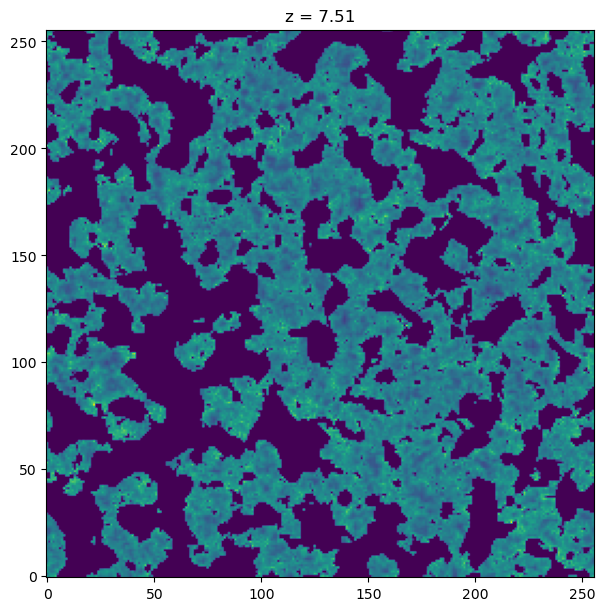

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
plt.title(f"z = {z[0]:.2f}")
plt.imshow(Tb[:,:,0], origin='lower')

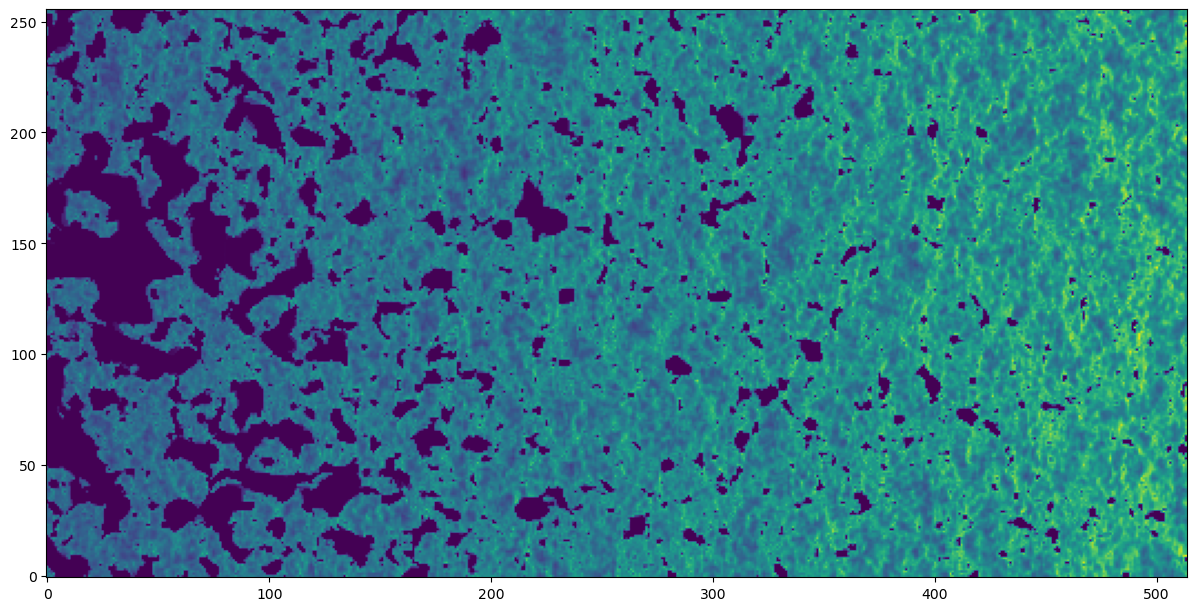

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
# plt.title(f"z = {z[0]:.2f}")
plt.imshow(Tb[0], origin='lower')

In [71]:
Tb = small[-1]

In [70]:
for i in range(Tb.shape[0]):
    fig, ax = plt.subplots(1, 1, figsize=(16,3), constrained_layout=True, dpi=200)
    # plt.title(f"z = {z[i]:.2f}")
    plt.imshow(Tb[i,:,:], origin='lower')
    plt.savefig(f"coeval{Tb.shape[0]-i-1:03d}.png")
    plt.close()
    # if i > 1:
    #     break

In [13]:
lightcone.brightness_temp.shape

(256, 256, 514)

In [14]:
lightcone.lightcone_distances[-1] - lightcone.lightcone_distances[0]

1028.0

In [15]:
lightcone.lightcone_distances.shape

(514,)

In [16]:
lightcone.shape

(256, 256, 514)

In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

filename = '/storage/home/hcoda1/3/bxia34/scratch/SmallScale21cmData.h5'
with h5py.File(filename, 'r') as f:
    print(f.keys())
    brightness_temp = np.array(f['brightness_temp'])
    print("brightness_temp.shape =", brightness_temp.shape)
    print(f['kwargs'])
    kwargs = np.array(list(f['kwargs']))
    print("kwargs =")
    print(kwargs)
    print(f['params_seeds'])
    params_keys = list(f['params_seeds']['keys'])
    print("params.keys =", params_keys)
    params_values = np.array(list(f['params_seeds']['values']))
    seeds = params_values[:,-1]
    print("params.values =")
    print(params_values[:10,:])
    print(np.round(params_values[:10, -1]))
    large = brightness_temp
    large_values = params_values[:,:-1]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances']>


In [7]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

filename = '/storage/home/hcoda1/3/bxia34/scratch/SmallScale21cmData.h5'
with h5py.File(filename, 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    print(f['params_seeds'].keys())
    print(f['params_seeds']['values'])
    seeds = np.array(f['params_seeds']['values'][:,2])

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances']>
<HDF5 dataset "brightness_temp": shape (400, 128, 128, 2050), type "<f4">
<KeysViewHDF5 ['keys', 'values']>
<HDF5 dataset "values": shape (400, 3), type "<f8">


In [13]:
np.unique(seeds).shape

(400,)

In [19]:
seeds[:5]

array([3.36212980e+09, 5.70451951e+08, 2.77332314e+09, 3.77314961e+09,
       1.07991101e+09])

In [20]:
seeds.astype(int)[:5]

array([3362129804,  570451951, 2773323145, 3773149614, 1079911012])

In [21]:
ls

diffusion.ipynb*        generate_dataset.sbatch  Report-5302094  Report-5302728
generate_dataset.ipynb  README.md                Report-5302240  Report-5302778
generate_dataset.py     Report-5263197           Report-5302721


In [22]:
cd

/storage/home/hcoda1/3/bxia34


In [23]:
ls


ondemand/  p-jw254-0@  scratch@


In [24]:
cd scratch

/storage/scratch1/3/bxia34


In [25]:
ls


ares/
cifar-10-batches-py/
data/
datasets/
ddpm-butterflies-128/
downloads/
hdf5/
huggan___smithsonian_butterflies_subset/
MNIST/
models--CompVis--stable-diffusion-v1-4/
models--google--ddpm-cat-256/
models--openai--diffusers-cd_bedroom256_lpips/
models--openai--diffusers-cd_imagenet64_l2/
models--runwayml--stable-diffusion-v1-5/
models--Xsmos--test_model/
__pycache__/
slurm_mpi_example/
SmallScale21cmData.h5
test/
test_empty/
test_load_dataset/


In [30]:
import glob
cache_pattern = "*.h5"
for filename in glob.glob(cache_pattern):
    print('start')
    print(filename)
    print('end')
    os.remove(filename)

In [32]:
glob.glob(cache_pattern)

[]

In [33]:
import py21cmfast as p21c
p21c.__path__

/storage/home/hcoda1/3/bxia34/.conda/envs/21cmFAST/lib/python3.9/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/storage/home/hcoda1/3/bxia34/.conda/envs/21cmFAST/lib/python3.9/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


['/storage/home/hcoda1/3/bxia34/.conda/envs/21cmFAST/lib/python3.9/site-packages/py21cmfast']